In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
import matplotlib.dates as mdates
import math
from scipy import interpolate, stats, special
from scipy import arange, array, exp
from astropy.coordinates import SkyCoord
import scipy as sc
from scipy import optimize

RAD2DEG = 180./np.pi
DEG2RAD=np.pi/180

In [2]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [3]:
# angular separation between two events
def spcang (ra1, ra2, dec1, dec2):
    return np.arccos(np.cos(dec1*DEG2RAD)*np.cos(dec2*DEG2RAD)*np.cos((ra1-ra2)*DEG2RAD)+np.sin(dec1*DEG2RAD)*np.sin(dec2*DEG2RAD))*RAD2DEG
    
# calculating signalness for IceCube events    
def signaless(n):
    normed_hist = \
    [  0.00000000e+00,  5.99855625e-06,  2.56068410e-06,  2.00041249e-04,
       4.96561472e-01,  1.80710446e+00,  1.53757070e+00,  6.19210631e-01,
       2.69402835e-01,  1.04740183e-01,  7.86432556e-02,  4.19244509e-02,
       2.51411438e-02,  9.83825515e-03,  4.66870813e-03,  2.57092417e-03,
       1.48438797e-03,  6.00967147e-04,  2.68416599e-04,  6.06027188e-05]
    bins_log10_signalness = \
    [-4., -3.8, -3.6, -3.4, -3.2, -3.,  -2.8, -2.6, -2.4, -2.2, -2.,  -1.8, -1.6, -1.4, -1.2,
     -1., -0.8, -0.6, -0.4, -0.2,  0. ]
    
    bins = np.asarray(bins_log10_signalness)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    
    f2 = interp1d(bin_centers, normed_hist)
    xnew=np.linspace(-3.8,-0.1,40)
    
    cdf = np.cumsum(f2(xnew))
    cdf = cdf / cdf[-1]
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = xnew[value_bins]
    return random_from_cdf

# Method 1: Likelihood function for each gamma-neutrino pair
def LLH(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    #Setting variables
    spc = spcang(ra1, ra2, dec1, dec2)
    
    ra1=ra1*DEG2RAD
    dec1=dec1*DEG2RAD
    ra2=ra2*DEG2RAD
    dec2=dec2*DEG2RAD
    
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    
    #Finding the best position using Colin's approach
    #first combine uncertainties
    sigma=1/(1/sigma1**2+1/sigma2**2)
    #now we calculate f, the distance from particle 1 to best fit position
    f=sigma/sigma2**2 #f should be between 0 and 1
    #define some intermediate parameters
    a=np.sin((1-f)*spc*DEG2RAD)/np.sin(spc*DEG2RAD)
    b=np.sin(f*spc*DEG2RAD)/np.sin(spc*DEG2RAD)
    x=a*np.cos(dec1)*np.cos(ra1)+b*np.cos(dec2)*np.cos(ra2)
    y=a*np.cos(dec1)*np.sin(ra1)+b*np.cos(dec2)*np.sin(ra2)
    z=a*np.sin(dec1)+b*np.sin(dec2)
    #now plug these parameters into the arctan2 function (quadrant sensitive arctangent) to find the best fit ra,dec
    ra0=np.arctan2(y,x)
    dec0=np.arctan2(z,np.sqrt(x**2+y**2))
    ra0%=2*np.pi #use modulo operator to make sure ra falls between 0 and 2pi
    ra_best=ra0*RAD2DEG
    dec_best=dec0*RAD2DEG
    if ra_best < 0 : ra_best = ra_best + 360
    else : ra_best = ra_best
    #print dec1*RAD2DEG, dec2*RAD2DEG, dec_best, ra1*RAD2DEG, ra2*RAD2DEG, ra_best, a, b
    
    #Calculating the likelihood
    #Spatial coincidence
    sigmac=(sigma1*DEG2RAD)**2+ (sigma2*DEG2RAD)**2 #Being conservative in the error  
    xerf=(spc*DEG2RAD)**2/(2*sigmac)#(np.sqrt(2)*np.sqrt(sigmac))
    term1 = -np.log(2*np.pi*sigmac)/2 - xerf
    #Db = (np.log(0.25*(sig1**2/sig2**2 + sig2**2/sig1**2 + 2)) + xerf)*0.25
    #BC = np.exp(-Db) #Bhattacharyya distance
    #H = 1 - BC #
    #term1 = np.log(BC)-np.log(H) #Bigger value, means gaussian are similar to each other. 
    #if xerf<5.:
    #pdst = special.erf(xerf) #Probability of distance being less than ∆theta
    #if pdst==1.: print xerf
    #pndst = 1 - pdst #probability distance begin more than ∆theta
    #term1 = np.log(pdst) - np.log(pndst)#-np.log(2*np.pi*sigc)/2
    #    else:
    #        pndst = special.erfc(xerf)
    #        term1 = -pndst - np.log(pndst)
    #        if term1==inf: print pndst,xerf,sig2,sig1,dst
    
    #IC and HAWC contributions
    #HAWC Signficance sig=2[ln(p(data|signal+bkg))-ln(p(data|bkg))]
    phwc = stats.norm.cdf(sig) #HAWC significances
    pIC = np.power(10,signaless(1))[0] #IC Signaless
    if pIC!=1: 
        term2 = -np.log(phwc) + np.log(pIC) - np.log(1-pIC)#sig**2  
    else:
        term2 = -np.log(phwc)
        
    llh = term1 + term2
    
    return [dec_best, ra_best, np.sqrt(sigma), np.sqrt(sigmac), term1, term2, llh] 

    #if dst/(np.sqrt(2)*sigc)<6.:
        #llh = term1 + term2 #+ term3  ##LIKELIHOOD
    #else:
        #llh = term1 #should be -20

# Cut events on time and angular space, calculate likelihood (use method 1) for the selected pairs,
# and save results in a new dataframe 
def spcang_trange_llh (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            #th1 = SkyCoord(h[1][1],h[1][0],unit='deg')
            #th2 = SkyCoord(ic[1][1],ic[1][0],unit='deg')
            #spc = th1.separation(th2).value
            
            if spc < minspc :
                #print i,j
                llh_list = LLH(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[2], llh_list[3], llh_list[4], llh_list[5],llh_list[6]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','SigQ','T1','T2','LLH'])
    return result


In [4]:
# Read HAWC data file
dfh = pd.read_csv("hawc_data_2.csv")
dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])

In [5]:
sigma_hawc = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=len(dfh), random_state=None)#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
dfh['HsigmaR']=sigma_hawc

In [6]:
dfh.head(5)

,HDec,HRA,HsigmaR,HTime_i,HTime_c,HTime_f,Hduration,Hsig
0,15.326700,265.650,0.103884,2016-01-01 14:00:24,2016-01-01 17:29:19,2016-01-01 20:58:14,6.96373,2.96086
1,-8.423330,256.377,0.155806,2016-01-01 14:03:17,2016-01-01 16:52:28,2016-01-01 19:41:39,5.63943,2.85261
2,18.170600,267.100,0.091443,2016-01-01 14:03:52,2016-01-01 17:35:05,2016-01-01 21:06:18,7.04071,3.16471
3,-0.708832,261.123,0.116191,2016-01-01 14:04:34,2016-01-01 17:11:22,2016-01-01 20:18:10,6.22688,3.03762
4,29.398700,268.814,0.087220,2016-01-01 14:06:01,2016-01-01 17:41:50,2016-01-01 21:17:39,7.19386,2.79077


In [7]:
# Read IceCube data file
dfic = pd.read_csv("ic-singlet-jan16.csv")
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')

In [8]:
dfic['ICFPRD'] = np.power(10,signaless(len(dfic)))
dfic.head(5)


,ICDec,ICRA,ICsigmaR,ICtime,ICmsec,ICFPRD
0,-34.7199,205.1050,0.196344,2016-01-01 00:04:57,98664,0.005223
1,54.3056,107.9430,0.534230,2016-01-01 00:05:40,122278,0.002180
2,57.3919,108.1390,1.176690,2016-01-01 00:05:48,730722,0.001408
3,-32.6259,332.9440,0.175290,2016-01-01 00:06:08,981306,0.002712
4,22.6634,20.1443,2.750110,2016-01-01 00:15:24,288569,0.001752


## Method 2: Calculate log-likelihood for multiplets, adding spatial terms for each event (photons or neutrinos) once with and once without temporal term 

In [9]:
# Define an initial space log-likelihood for each event (dec and ra are coordinates of the source position)
def loglh(dec1,ra1,dec,ra,sigma1,bkgterm):
    spc=np.deg2rad(spcang(ra1,ra,dec1,dec))
    #s = np.deg2rad(sigma1)**2+np.deg2rad(sigma)**2
    return -spc**2/(2*(np.deg2rad(sigma1))**2) - 0.5*np.log(2*np.pi*(np.deg2rad(sigma1))**2)-np.log(bkgterm)
    #return -spc**2/(2*s)-1/2*np.log(2*np.pi*s)#-np.log(bkgterm)

# Find total log-likelihood considering multiplets: only spatial terms
def tloglh(dec,ra,events):
    val = 0
    for nut in events:
        dec1 = nut[0]
        ra1 = nut[1]
        sigma1 = nut[2]
        bkg=nut[4]
        # adding log-likelihood spatial terms
        val = val + loglh(dec1,ra1,dec,ra,sigma1,bkg)
    return val

# Find total log-likelihood considering multiplets: spatial and temporal terms
#def tloglh_time(dec,ra,events,T = 1e6):
def tloglh_time(dec,ra,events):
    val = 0
    for nut in events:
        dec1 = nut[0]
        ra1 = nut[1]
        sigma1 = nut[2]
        bkg=nut[4]
        # adding log-likelihood spatial terms
        val = val + loglh(dec1,ra1,dec,ra,sigma1,bkg)
    if len(events) > 2:
        for i in range(1,len(events)-1) :
            for j in range(i+1,len(events)) :
                # adding temporal term (T is a normlization factor that can be modified to match spatial terms)
                #val = val - abs(((events[i][3]-events[j][3])).seconds)/T
                val = val - abs(((events[i][3]-events[j][3])).seconds)/(events[0][3]*3600.) - np.log(events[0][3]*3600.)
    return val

In [23]:
# Create a list of lists where each secondary list contains the photon event information and all its paired neutrinos
# photon: [RA, Dec, SigmaR], neutrino: [RA, Dec, SigmaR, timestamp]
minspc=3.5
FOV = np.deg2rad(50.)
hwcArea = 2.*np.pi*(1-np.cos(FOV))
all_event_list=[]
for h in dfh.itertuples():
    dfw=dfic[(pd.to_datetime(h.HTime_i)<=pd.to_datetime(dfic['ICtime']))&(pd.to_datetime(h.HTime_f)>=pd.to_datetime(dfic['ICtime']))]
    event_list=[]
    event_list.append([h.HDec,h.HRA,h.HsigmaR,h.Hduration,1-stats.norm.cdf(h.Hsig)])
    for ic in dfw.itertuples():
        spc=spcang(h.HRA,ic.ICRA,h.HDec,ic.ICDec)
        if spc<minspc:
            event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), ic.ICFPRD])
    all_event_list.append(event_list)
#print all_event_list

In [24]:
# list of events with at least one neutrino paired with the photon
all_ev_nut = [x for x in all_event_list if len(x)>1]

In [25]:
all_ev_nut[0]

[[-8.42333,
  256.37700000000001,
  0.10053729110595615,
  5.6394299999999999,
  0.0021680901046019496],
 [-6.1167499999999997,
  258.08199999999999,
  0.62114399999999992,
  Timestamp('2016-01-01 17:32:47'),
  0.0064986105733132009]]

In [26]:
# Use Scipy optimizer to find the Maximum likelihood and source position
# Case of llh with spatial terms: 
best_fit_val = []
TempTerm=True
for ev in all_ev_nut:
    if TempTerm:
        solution = sc.optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
    else:
        solution = sc.optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'BFGS')
    res = list(solution.x)
    stderr = 0.
    jacerr = 0.
    avgdist = 0.
    stddev = 0.
    j=0
    n=0

    if solution.success:
        for part in ev:
            #print part[0],part[1],part[2],solution.x[0],solution.x[1]
            stderr += 1./(part[2]**2)
            tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
            tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
            stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
            avgdist +=tmpdist1#+ tmpdist2
            #print tmpdist1, tmpdist2
            j+=1
        #print avgdist,solution.fun
        stderr = np.sqrt(1/stderr)
        jacerr = np.sqrt(jacerr)
        avgdist /= j
        stddev /= j
        stddev = np.sqrt(stddev)
    
        res.append(stderr)
        #res.append(jacerr)
        res.append(-1*solution.fun)
        res.append(avgdist)
        res.append(stddev)
        res.append(len(ev)-1)
        res.append(ev)
        best_fit_val.append(res)
        
# Case of llh with spatial and temporal terms: 
# best_fit_val_time = []
# for ev in all_ev_nut:
#     solution = sc.optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'BFGS')
#     res = list(solution.x)
#     stderr = 0
#     avgdist = 0.
#     stddev = 0.
#     jacerr = 0.
#     j=0
#     n=0
#     for part in ev:
#         stderr += 1/(part[2]**2)
#         avgdist += abs(spcang(solution.x[1],part[1],solution.x[0],part[0]))/part[2]
#         stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
#         j+=1
#     stderr = np.sqrt(1/stderr)
#     avgdist /= j
#     stddev /= j
#     stddev = np.sqrt(stddev)
    
#     res.append(stderr)
#     #res.append(jacerr)
#     res.append(solution.fun)
#     res.append(avgdist)
#     res.append(stddev)
#     res.append(len(ev)-1)
#     res.append(ev)
#     best_fit_val_time.append(res)

In [27]:
solution

     fun: -19.558533487929136
     jac: array([ 0.00122857,  0.00302148])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 27.77109145,  47.38962089])

In [28]:
best_fit_val[0]

[-8.3644935519635553,
 256.42077190492421,
 0.099245671963623397,
 9.871426591091245,
 2.6068244099406872,
 1.9714411484203171,
 1,
 [[-8.42333,
   256.37700000000001,
   0.10053729110595615,
   5.6394299999999999,
   0.0021680901046019496],
  [-6.1167499999999997,
   258.08199999999999,
   0.62114399999999992,
   Timestamp('2016-01-01 17:32:47'),
   0.0064986105733132009]]]

In [ ]:
#best_fit_val_time[0]

In [29]:
#Values to plot
likelihood = np.asarray([x[3] for x in best_fit_val])
likelihood_pair = np.asarray([x[3] for x in best_fit_val if len(x[7]) <= 2])
likelihood_mult = np.asarray([x[3] for x in best_fit_val if len(x[7]) > 2])

avgDist = np.asarray([x[4] for x in best_fit_val])
avgDist_pair = np.asarray([x[4] for x in best_fit_val if len(x[7]) <= 2])
avgDist_mult = np.asarray([x[4] for x in best_fit_val if len(x[7]) > 2])

dec_test=np.asarray([x[0] for x in best_fit_val])
dec_pair=np.asarray([x[0] for x in best_fit_val if len(x[7]) <= 2])
dec_mult=np.asarray([x[0] for x in best_fit_val if len(x[7]) > 2])

ra_test=np.asarray([x[1] for x in best_fit_val])
ra_pair=np.asarray([x[1] for x in best_fit_val if len(x[7]) <= 2])
ra_mult=np.asarray([x[1] for x in best_fit_val if len(x[7]) > 2])

In [17]:
# # maximum llh values (case of no temporal term)
# likelihood = [x[3] for x in best_fit_val]
# avgAng = [x[4] for x in best_fit_val]
# stdAng = [x[5] for x in best_fit_val]

In [18]:
# # maximum llh values (case of no temporal term) for cases with more than one neutrinos
# likelihoods_2 = [x[3] for x in best_fit_val if len(x[7]) <= 2]
# avgAng_2 = [x[4] for x in best_fit_val if len(x[7]) <= 2]
# stdAng_2 = [x[5] for x in best_fit_val if len(x[7]) <= 2]

In [19]:
# # maximum llh values (case of having the temporal term)
# likelihoods_time1 = [x[3] for x in best_fit_val_time]
# avgAng_time1 = [x[4] for x in best_fit_val_time]
# stdAng_time1 = [x[5] for x in best_fit_val_time]

In [20]:
# # maximum llh values (case of having the temporal term) for cases with more than one neutrinos
# likelihoods_time2 = [x[3] for x in best_fit_val_time if len(x[7]) <= 2]
# avgAng_time2 = [x[4] for x in best_fit_val_time if len(x[7]) <= 2]
# stdAng_time2 = [x[5] for x in best_fit_val_time if len(x[7]) <= 2]

In [30]:
len(likelihood)

2493

In [ ]:
len(avgDist)

In [29]:
i=0
j=0
for x in best_fit_val:
    if len(x[7]) > 2:
        print j
        print x
        print " "
        if i==1:
            break
        i+=1
    j+=1

33
[2.7247710025811922, 27.752783183876755, 0.066926851862539757, 9.594448951739139, 1.8832388005613883, 2.3355239185441961, 2, [[2.7239900000000001, 27.773499999999999, 0.067305000856948849, 6.4373399999999998, 0.0029661509909671979], [-0.50077199999999999, 26.5304, 1.48966, Timestamp('2016-01-01 23:49:36'), 0.0017522244804127837], [3.51519, 25.789899999999999, 0.69826100000000002, Timestamp('2016-01-02 02:00:28'), 0.002180025323490052]]]
 
37
[38.719166934724413, 39.740902943178703, 0.070959933268880365, 16.44967072567074, 0.74959709329258228, 1.4581626702346897, 2, [[38.729900000000001, 39.726599999999998, 0.071732999975872264, 7.1071100000000005, 0.0016475343740576243], [38.206499999999998, 40.3598, 0.48801800000000001, Timestamp('2016-01-02 03:19:12'), 0.0014083738370720183], [39.794400000000003, 42.548299999999998, 4.1283699999999994, Timestamp('2016-01-02 05:50:52'), 0.0014083738370720183]]]
 


In [30]:
i=0
j=0
for x in best_fit_val:
    if len(x[7]) > 2:
        print j        
        print x
        print " "
        if i==2:
            break
        i+=1
    j+=1

33
[2.7247710025811922, 27.752783183876755, 0.066926851862539757, 9.594448951739139, 1.8832388005613883, 2.3355239185441961, 2, [[2.7239900000000001, 27.773499999999999, 0.067305000856948849, 6.4373399999999998, 0.0029661509909671979], [-0.50077199999999999, 26.5304, 1.48966, Timestamp('2016-01-01 23:49:36'), 0.0017522244804127837], [3.51519, 25.789899999999999, 0.69826100000000002, Timestamp('2016-01-02 02:00:28'), 0.002180025323490052]]]
 
37
[38.719166934724413, 39.740902943178703, 0.070959933268880365, 16.44967072567074, 0.74959709329258228, 1.4581626702346897, 2, [[38.729900000000001, 39.726599999999998, 0.071732999975872264, 7.1071100000000005, 0.0016475343740576243], [38.206499999999998, 40.3598, 0.48801800000000001, Timestamp('2016-01-02 03:19:12'), 0.0014083738370720183], [39.794400000000003, 42.548299999999998, 4.1283699999999994, Timestamp('2016-01-02 05:50:52'), 0.0014083738370720183]]]
 
38
[39.424227947105209, 39.988442137307416, 0.14822338143481889, 17.474312932576154, 1

In [31]:
# all info (best fit position, llh values, event info) (case of having the temporal term) for large llh values
#likelihoods_time3 = [x for x in best_fit_val_time if x[3] > 100]

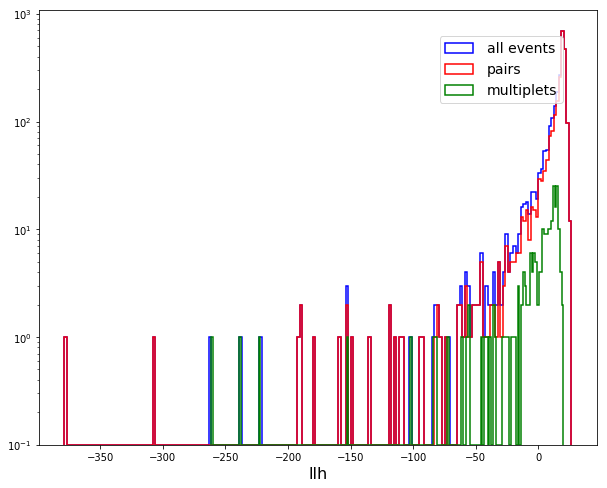

In [31]:
# Plot the histogram of llh values

_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         #range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         #range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         #range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(bbox_to_anchor=(0.94,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)
#savefig('llh_multiplets.png')

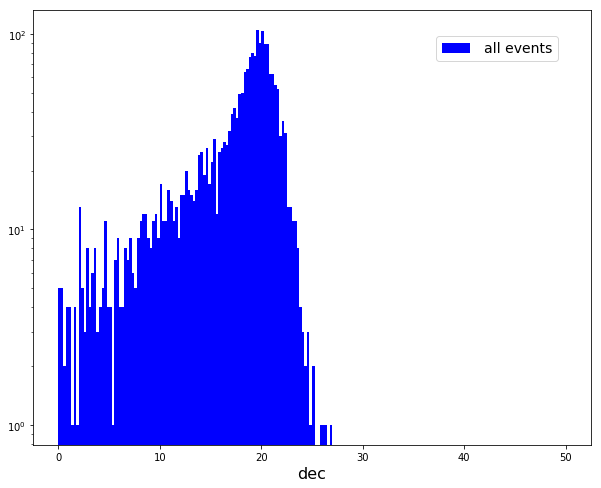

In [221]:
# # Plot the histogram of llh values

_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=[0,50],
         label=r'all events')
# _=plt.hist(,
#          #cumulative=True,normed=1,histtype='step',
#          log=True,
#          color='r',
#          lw=1.5,
#          bins=100,
#          alpha=0.5,
#          label=r'multiplets')
l=legend(bbox_to_anchor=(0.94,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'dec',fontsize=16)
#savefig('llh_multiplets_spc.png')

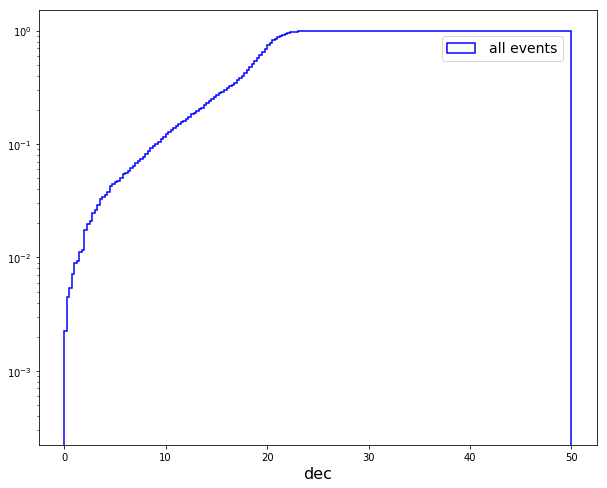

In [222]:
_=plt.hist(likelihood,
         cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=[0,50],
         label=r'all events')
# _=plt.hist(,
#          #cumulative=True,normed=1,histtype='step',
#          log=True,
#          color='r',
#          lw=1.5,
#          bins=100,
#          alpha=0.5,
#          label=r'multiplets')
l=legend(bbox_to_anchor=(0.94,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'dec',fontsize=16)

In [79]:
# rcParams['figure.figsize']=16,6
# x=np.arange(len(likelihoods_2))
# mini=100
# maxi=150
# y1=np.asarray(likelihood)
# y2=np.asarray(likelihoods_time2)
# bar(x[mini:maxi],y1[mini:maxi],width = 0.7,color='r',alpha=0.9,label='only space')
# bar(x[mini:maxi],y2[mini:maxi],width = 0.6,color='g',alpha=0.5,label='with time argument')
# bar(x[mini:maxi],y2[mini:maxi]-y1[mini:maxi],width = 0.5,color='b',alpha=0.7,label='time argument')
# legend()

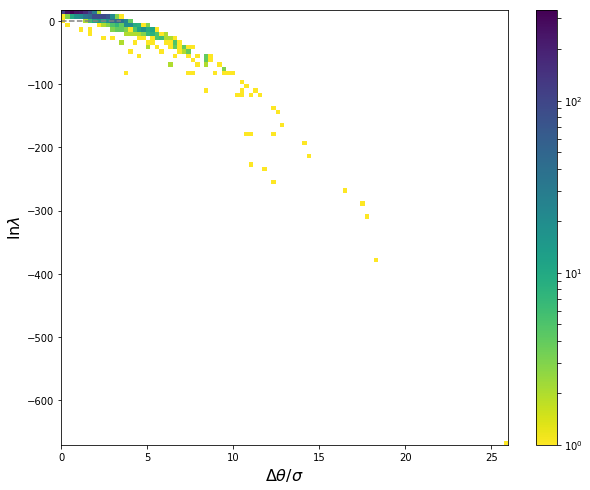

In [102]:
from matplotlib.colors import LogNorm
rcParams['figure.figsize'] = (10, 8)
hist2d(avgDist,likelihood,bins=100,cmap='viridis_r',norm=LogNorm())#,range=[(-500,0),(-10,350)])
colorbar()
xlabel(r"$\Delta \theta / \sigma$",fontsize=16)
ylabel(r'$\ln \lambda$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')

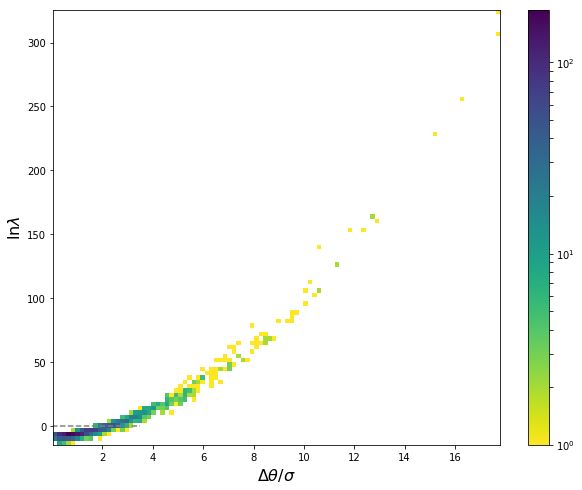

In [81]:
from matplotlib.colors import LogNorm
rcParams['figure.figsize'] = (10, 8)
hist2d(avgDist_pair,likelihood_pair,bins=100,cmap='viridis_r',norm=LogNorm())#,range=[(0,20),(-10,350)])
colorbar()
xlabel(r"$\Delta \theta / \sigma$",fontsize=16)
ylabel(r'$\ln \lambda$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')

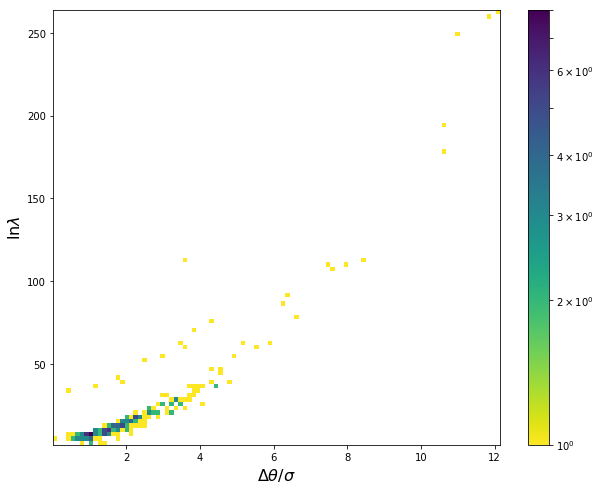

In [82]:
from matplotlib.colors import LogNorm
rcParams['figure.figsize'] = (10, 8)
hist2d(avgDist_mult,likelihood_mult,bins=100,cmap='viridis_r',norm=LogNorm())#,range=[(0,20),(-10,350)])
colorbar()
xlabel(r"$\Delta \theta / \sigma$",fontsize=16)
ylabel(r'$\ln \lambda$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')

In [21]:
%%time
#Using several simulations
# Create a list of lists where each secondary list contains the photon event information and all its paired neutrinos
# photon: [RA, Dec, SigmaR], neutrino: [RA, Dec, SigmaR, timestamp]
minspc=3.5
#best_fit_val_time = []
best_fit_val = []
TempTerm=True

# Read HAWC data file
dfh = pd.read_csv("hawc_data_2.csv")
dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
sigma_hawc = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=len(dfh), random_state=None)#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
dfh['HsigmaR']=sigma_hawc

#Combine the HAWC month of data with 1000 scrambled months of IC data. -> Simulating 1000 months of data. 
for i in xrange(60):
    #HAWC sim
    #dfh = pd.read_csv("HAWC_simulations/2016-01-01_{}-times.txt".format(i+1),delimiter=" ")
    #dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
    #dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
    #IC sim
    dfic = pd.read_csv("IC_scrambled/{}.csv".format(i))
    dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
    dfic = dfic.sort_values(by='ICtime')
    dfic['ICFPRD'] = np.power(10,signaless(len(dfic)))


    all_event_list=[]
    for h in dfh.itertuples():
        dfw=dfic[(pd.to_datetime(h.HTime_i)<=pd.to_datetime(dfic['ICtime']))&(pd.to_datetime(h.HTime_f)>=pd.to_datetime(dfic['ICtime']))]
        event_list=[]
        #sigma = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
        event_list.append([h.HDec,h.HRA,h.HsigmaR,h.Hduration,1-stats.norm.cdf(h.Hsig)])
        for ic in dfw.itertuples():
            spc=spcang(h.HRA,ic.ICRA,h.HDec,ic.ICDec)
            if spc<minspc:
                event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), ic.ICFPRD])
        all_event_list.append(event_list)
        all_ev_nut = [x for x in all_event_list if len(x)>1]
    
    
    
    for ev in all_ev_nut:
        if TempTerm:
            solution = sc.optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
        else:
            solution = sc.optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'BFGS')
        res = list(solution.x)
        stderr = 0.
        jacerr = 0.
        avgdist = 0.
        stddev = 0.
        j=0
        n=0

        if solution.success:
            for part in ev:
                #print part[0],part[1],part[2],solution.x[0],solution.x[1]
                stderr += 1./(part[2]**2)
                tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
                tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
                stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
                avgdist +=tmpdist1#+ tmpdist2
                #print tmpdist1, tmpdist2
                j+=1
            #print avgdist,solution.fun
            stderr = np.sqrt(1/stderr)
            jacerr = np.sqrt(jacerr)
            avgdist /= j
            stddev /= j
            stddev = np.sqrt(stddev)
    
            res.append(stderr)
            #res.append(jacerr)
            res.append(-1*solution.fun)
            res.append(avgdist)
            res.append(stddev)
            res.append(len(ev)-1)
            res.append(ev)
            best_fit_val.append(res)
    

CPU times: user 1h 59min 30s, sys: 49.4 s, total: 2h 19s
Wall time: 2h 2min 14s


In [22]:
#Values to plot
likelihood = np.asarray([x[3] for x in best_fit_val])
likelihood_pair = np.asarray([x[3] for x in best_fit_val if len(x[7]) <= 2])
likelihood_mult = np.asarray([x[3] for x in best_fit_val if len(x[7]) > 2])

avgDist = np.asarray([x[4] for x in best_fit_val])
avgDist_pair = np.asarray([x[4] for x in best_fit_val if len(x[7]) <= 2])
avgDist_mult = np.asarray([x[4] for x in best_fit_val if len(x[7]) > 2])

dec_test=np.asarray([x[0] for x in best_fit_val])
dec_pair=np.asarray([x[0] for x in best_fit_val if len(x[7]) <= 2])
dec_mult=np.asarray([x[0] for x in best_fit_val if len(x[7]) > 2])

ra_test=np.asarray([x[1] for x in best_fit_val])
ra_pair=np.asarray([x[1] for x in best_fit_val if len(x[7]) <= 2])
ra_mult=np.asarray([x[1] for x in best_fit_val if len(x[7]) > 2])

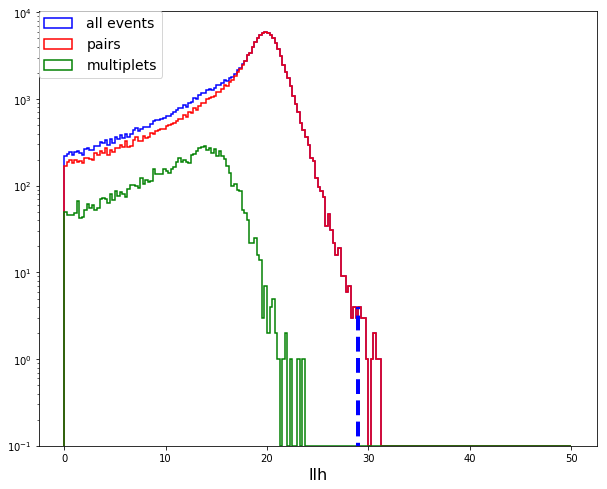

In [30]:
# Plot the histogram of llh values
alpha = 0.0001
p=(1-alpha)*100
perc1 = np.percentile(likelihood,p)
llh=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)
h=np.searchsorted(llh[1],perc1)-1
plt.vlines(perc1,0,llh[0][h],color='b',linestyles='--',lw=4)
#ylim(1e-1,1e4)
#savefig('llh_multiplets_positive.png')

In [29]:
np.searchsorted(llh[1],perc1)
len(likelihood[likelihood>perc1])/60.

0.26666666666666666

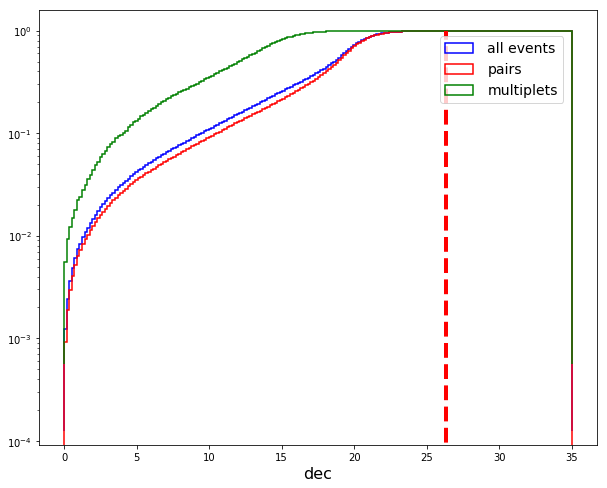

In [18]:
_=plt.hist(likelihood,
         cumulative=True,normed=1,
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=[0,35],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         cumulative=True,normed=1,
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         range=[0,35],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         cumulative=True,normed=1,
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         range=[0,35],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
# _=plt.hist(,
#          #cumulative=True,normed=1,histtype='step',
#          log=True,
#          color='r',
#          lw=1.5,
#          bins=100,
#          alpha=0.5,
#          label=r'multiplets')
l=legend(bbox_to_anchor=(0.94,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'dec',fontsize=16)
plt.vlines(perc1,0,p/100,color='r',linestyles='--',lw=4)

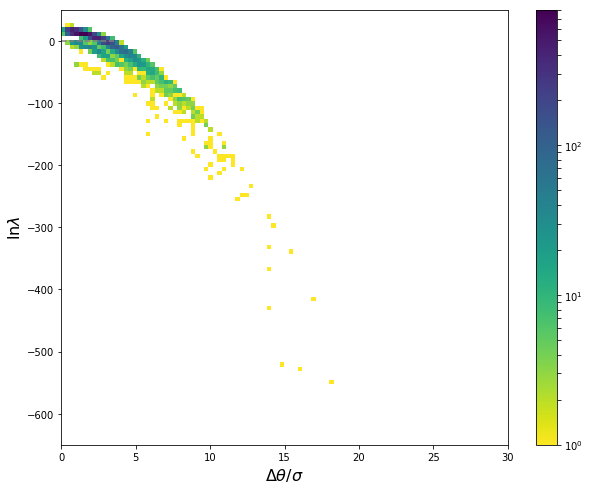

In [42]:
from matplotlib.colors import LogNorm
rcParams['figure.figsize'] = (10, 8)
hist2d(avgDist_mult,likelihood_mult,bins=100,cmap='viridis_r',norm=LogNorm(),range=[(0,30),(-650,50)])
colorbar()
xlabel(r"$\Delta \theta / \sigma$",fontsize=16)
ylabel(r'$\ln \lambda$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')
savefig('llh_multiplets_spc_multiplet.png')

## Permutation of simulations

In [57]:
#Using several simulations
# Create a list of lists where each secondary list contains the photon event information and all its paired neutrinos
# photon: [RA, Dec, SigmaR], neutrino: [RA, Dec, SigmaR, timestamp]
minspc=3.5
#best_fit_val_time = []
best_fit_val = []
TempTerm=True
for i in xrange(100):
    #HAWC sim
    dfh = pd.read_csv("HAWC_simulations/2016-01-01_{}-times.txt".format(i+1),delimiter=" ")
    dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
    dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
    #IC sim
    for j in xrange(100):
        dfic = pd.read_csv("IC_scrambled/{}.csv".format(i))
        dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
        dfic = dfic.sort_values(by='ICtime')
        dfic['ICFPRD'] = np.power(10,signaless(len(dfic)))


        all_event_list=[]
        for h in dfh.itertuples():
            dfw=dfic[(pd.to_datetime(h.HTime_i)<=pd.to_datetime(dfic['ICtime']))&(pd.to_datetime(h.HTime_f)>=pd.to_datetime(dfic['ICtime']))]
            event_list=[]
            #sigma = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
            event_list.append([h.HDec,h.HRA,h.HsigmaR,h.Hduration,1-stats.norm.cdf(h.Hsig)])
            for ic in dfw.itertuples():
                spc=spcang(h.HRA,ic.ICRA,h.HDec,ic.ICDec)
                if spc<minspc:
                    event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), ic.ICFPRD])
            all_event_list.append(event_list)
            all_ev_nut = [x for x in all_event_list if len(x)>1]
    
    
    
        for ev in all_ev_nut:
            if TempTerm:
                solution = sc.optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
            else:
                solution = sc.optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'BFGS')
            res = list(solution.x)
            stderr = 0.
            jacerr = 0.
            avgdist = 0.
            stddev = 0.
            j=0
            n=0

            if solution.success:
                for part in ev:
                    #print part[0],part[1],part[2],solution.x[0],solution.x[1]
                    stderr += 1./(part[2]**2)
                    tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
                    tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
                    stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
                    avgdist +=tmpdist1#+ tmpdist2
                    #print tmpdist1, tmpdist2
                    j+=1
                #print avgdist,solution.fun
                stderr = np.sqrt(1/stderr)
                jacerr = np.sqrt(jacerr)
                avgdist /= j
                stddev /= j
                stddev = np.sqrt(stddev)
    
                res.append(stderr)
                #res.append(jacerr)
                res.append(-1*solution.fun)
                res.append(avgdist)
                res.append(stddev)
                res.append(len(ev)-1)
                res.append(ev)
                best_fit_val.append(res)

In [58]:
#Values to plot
likelihood = np.asarray([x[3] for x in best_fit_val])
likelihood_pair = np.asarray([x[3] for x in best_fit_val if len(x[7]) <= 2])
likelihood_mult = np.asarray([x[3] for x in best_fit_val if len(x[7]) > 2])

avgDist = np.asarray([x[4] for x in best_fit_val])
avgDist_pair = np.asarray([x[4] for x in best_fit_val if len(x[7]) <= 2])
avgDist_mult = np.asarray([x[4] for x in best_fit_val if len(x[7]) > 2])

dec_test=np.asarray([x[0] for x in best_fit_val])
dec_pair=np.asarray([x[0] for x in best_fit_val if len(x[7]) <= 2])
dec_mult=np.asarray([x[0] for x in best_fit_val if len(x[7]) > 2])

ra_test=np.asarray([x[1] for x in best_fit_val])
ra_pair=np.asarray([x[1] for x in best_fit_val if len(x[7]) <= 2])
ra_mult=np.asarray([x[1] for x in best_fit_val if len(x[7]) > 2])

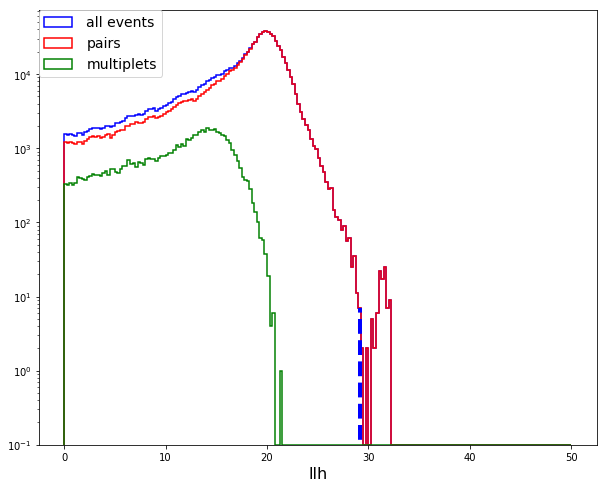

In [59]:
# Plot the histogram of llh values
alpha = 0.0001
p=(1-alpha)*100
perc1 = np.percentile(likelihood,p)
llh=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)
h=np.searchsorted(llh[1],perc1)-1
plt.vlines(perc1,0,llh[0][h],color='b',linestyles='--',lw=4)

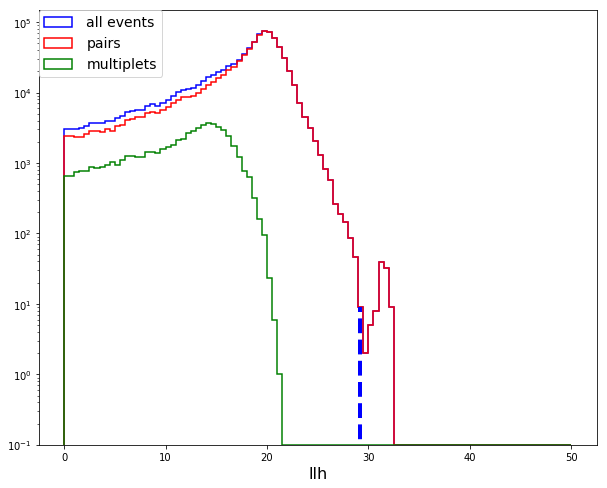

In [81]:
# Plot the histogram of llh values
alpha = 0.0001
p=(1-alpha)*100
perc1 = np.percentile(likelihood,p)
llh=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=100,
         range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=100,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=100,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)
h=np.searchsorted(llh[1],perc1)-1
plt.vlines(perc1,0,llh[0][h],color='b',linestyles='--',lw=4)

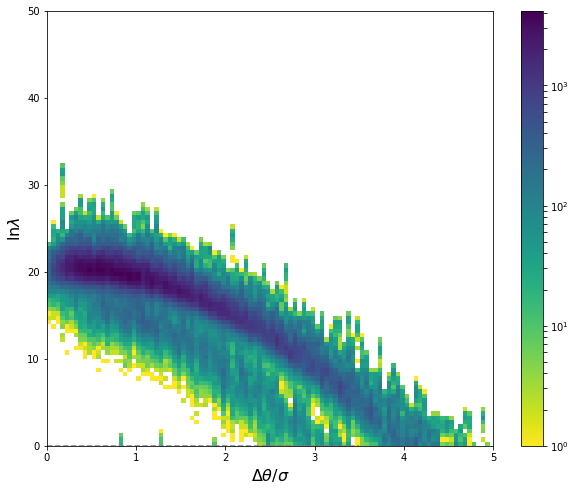

In [77]:
from matplotlib.colors import LogNorm
rcParams['figure.figsize'] = (10, 8)
hist2d(avgDist,likelihood,bins=[100,100],cmap='viridis_r',norm=LogNorm(),range=[(0,5),(0,50)])
colorbar()
xlabel(r"$\Delta \theta / \sigma$",fontsize=16)
ylabel(r'$\ln \lambda$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')

In [61]:
np.searchsorted(llh[1],perc1)
len(likelihood)

969700

## What we had previously:

In [27]:
%%time
spca = 3.5
# df_result1 = spcang_trange_llh1(dfic, dfh, spca)
# df_result1.to_csv("IC_HAWC_bkg_1.csv",index=False,encoding='utf-8')
# df_result2 = spcang_trange_llh2(dfic, dfh, spca)
# df_result2.to_csv("IC_HAWC_bkg_2.csv",index=False,encoding='utf-8')
df_result = spcang_trange_llh(dfic, dfh, spca)
df_result.to_csv("IC_HAWC_bkg.csv",index=False,encoding='utf-8')

CPU times: user 45 s, sys: 121 ms, total: 45.1 s
Wall time: 45.1 s


In [28]:
df_result.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,HDec,HRA,HsigmaR,HTime_i,HTime_c,HTime_f,Hduration,Hsig,SpcAng,Best_fit_dec,Best_fit_ra,Best_pos_err,SigQ,T1,T2,LLH
0,34.7977,275.113,1.795160,2016-01-01 20:01:02,33.3312,271.890,0.75,2016-01-01 14:18:31,2016-01-01 17:54:04,2016-01-01 21:29:37,7.18509,3.20798,3.045947,33.347330,271.923899,0.185693,0.031500,1.114729,-0.323293,0.791437
1,34.7977,275.113,1.795160,2016-01-01 20:01:02,34.5452,272.110,0.75,2016-01-01 14:19:41,2016-01-01 17:54:56,2016-01-01 21:30:11,7.17481,3.60946,2.482528,34.545868,272.116913,0.086267,0.031368,1.589039,0.825963,2.415002
2,16.6642,272.744,0.834174,2016-01-01 16:36:03,18.3277,271.934,0.75,2016-01-01 14:23:02,2016-01-01 17:54:22,2016-01-01 21:25:42,7.04470,2.96565,1.834115,18.313753,271.940861,0.076418,0.014621,0.909490,-2.385097,-1.475608
3,34.7977,275.113,1.795160,2016-01-01 20:01:02,35.8232,276.065,0.75,2016-01-01 14:35:54,2016-01-01 18:10:42,2016-01-01 21:45:30,7.15974,2.89521,1.286515,35.818705,276.060759,0.119063,0.031401,2.286321,-2.810190,-0.523869
4,26.6468,273.461,2.543030,2016-01-01 21:09:15,24.5012,276.328,0.75,2016-01-01 14:37:07,2016-01-01 18:11:51,2016-01-01 21:46:35,7.15769,3.39708,3.360062,24.503509,276.325007,0.082892,0.044408,1.323434,-0.793834,0.529600


In [29]:
len(df_result)

1367

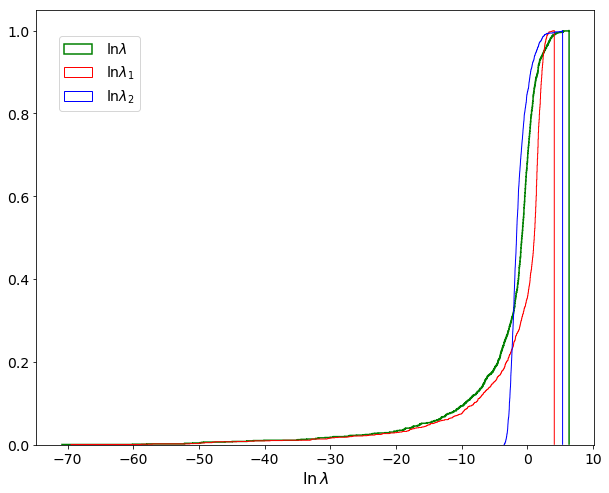

In [30]:
#rcParams['figure.figsize'] = (10, 8)
rcParams['font.size']=14
cllh=plt.hist(df_result.LLH,cumulative=True,normed=1,
         histtype='step',
         color='g',
         lw=1.5,
         bins=2000,
         label=r'$\ln \lambda$')
cllh1=plt.hist(df_result.T1,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=2000,
         label=r'$\ln \lambda_1$')
cllh2=plt.hist(df_result.T2,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=2000,
         label=r'$\ln \lambda_2$')
# cllh=plt.hist(df_result.T3,cumulative=True,normed=1,
#          histtype='step',
#          color='k',
#          lw=1.,
#          bins=2000,
#          label='T3')
#xlim(-20,70)
#perc2 = np.percentile(df_result.LLH,99.99)
#plt.vlines(perc2,0,0.9999,color='green',linestyles='--',lw=1.5)
l=legend(bbox_to_anchor=(0.04,0.94),loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'$\ln \, \lambda$',fontsize=16)
#savefig('/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/CLLH.pdf')

In [31]:
delta = (max(df_result.LLH)+10)/100.
binst1 = (max(df_result.T1)+10)/delta
binst2 = (max(df_result.T2)-min(df_result.T2))/delta
#binst3 = max(df_result.T3)-min(df_result.T3)/delta
#min(df_result.ICsigmaR)
binst1

86.21560622157773

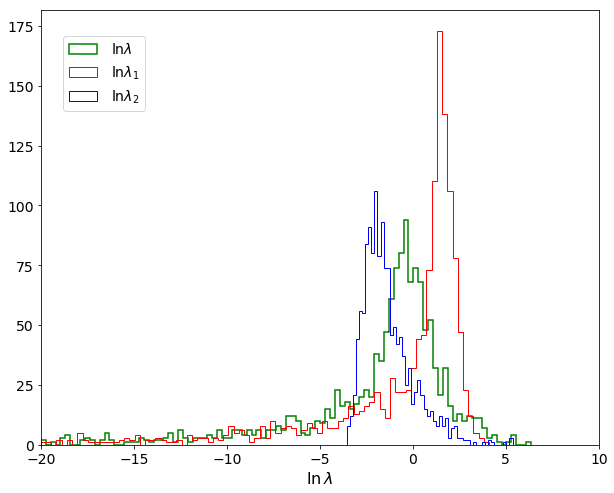

In [33]:
rcParams['figure.figsize'] = (10, 8)
# llh=plt.hist(df_result1.LLH,cumulative=False,normed=1,
#          histtype='step',
#          color='b',
#          lw=1.,
#          bins=200,
#          label='bkg')
# llh=plt.hist(df_result2.LLH,cumulative=False,normed=1,
#          histtype='step',
#          color='r',
#          lw=1.,
#          bins=200,
#          label='bkg')
llh=plt.hist(df_result.LLH,cumulative=False,normed=0,
         histtype='step',
         color='g',
         lw=1.5,
         bins=100,
         label=r'$\ln \lambda$',range=[-20,max(df_result.LLH)])
t1=plt.hist(df_result.T1,cumulative=False,normed=0,
         histtype='step',
         color='r',
         lw=1.,
         bins=int(binst1),
         label=r'$\ln \lambda_1$',range=[-20,max(df_result.T1)])
t2=plt.hist(df_result.T2,cumulative=False,normed=0,
         histtype='step',
         color='b',
         lw=1.,
         bins=int(binst2),
         label=r'$\ln \lambda_2$',range=[min(df_result.T2),max(df_result.T2)])
# t3=plt.hist(df_result.T3,cumulative=False,normed=0,
#          histtype='step',
#          color='k',
#          lw=1.,
#          bins=int(binst3),
#          label='T3')
l=legend(bbox_to_anchor=(0.04,0.94),loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})

xlabel("logLH")
xlim(-20,10)
xlabel(r'$\ln \, \lambda$',fontsize=16)
#yscale('log')
#savefig('/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/PLLH.pdf')

In [34]:
len(df_result.LLH)

1367

In [35]:
# from matplotlib.colors import LogNorm
# rcParams['figure.figsize'] = (10, 8)
# hist2d(df_result.T2,df_result.T2/df_result.LLH,bins=50,cmap='viridis_r',norm=LogNorm(),
#        range=[[-10,70], [-1,1]]
#       )

# xlabel(r"T2",fontsize=16)
# ylabel(r'T2/$\ln \lambda$',fontsize=16)
# #xlim(-10,0)
# #ylim(0,1)
# colorbar()
# #zscale('log')np.log(1-phwc)
# savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T2vsLLH.pdf")
max(df_result.LLH)

6.3498734127564331

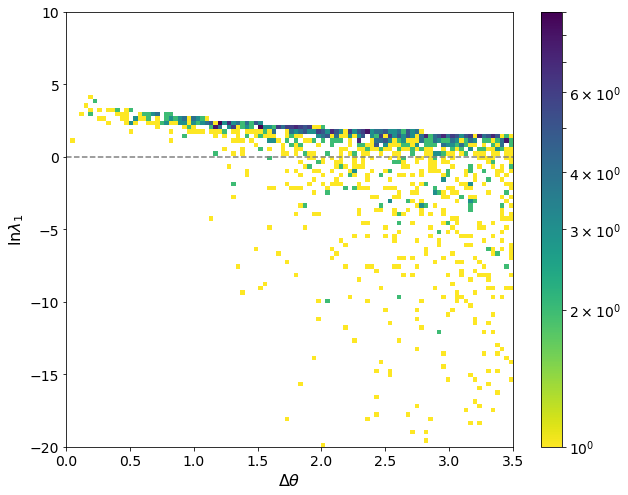

In [37]:
from matplotlib.colors import LogNorm
rcParams['figure.figsize'] = (10, 8)
hist2d(df_result.SpcAng,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm(),range=[(0,3.5),(-20,10)])
colorbar()
xlabel(r"$\Delta \theta$",fontsize=16)
ylabel(r'$\ln \lambda_1$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')
#savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsTheta.pdf")

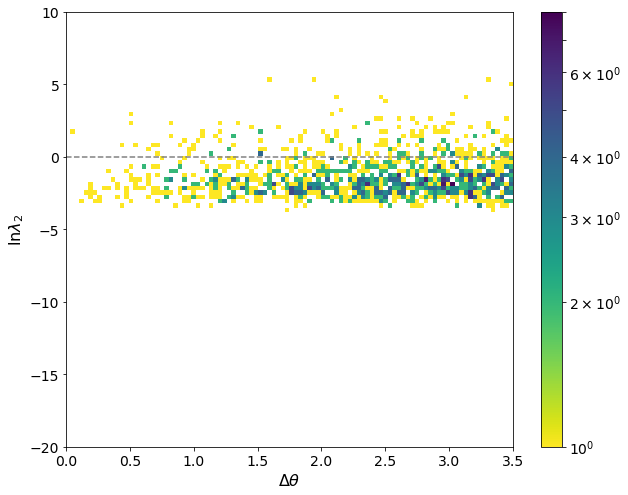

In [38]:
from matplotlib.colors import LogNorm
rcParams['figure.figsize'] = (10, 8)
hist2d(df_result.SpcAng,df_result.T2,bins=100,cmap='viridis_r',norm=LogNorm(),range=[(0,3.5),(-20,10)])
colorbar()
xlabel(r"$\Delta \theta$",fontsize=16)
ylabel(r'$\ln \lambda_2$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')
#savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T2vsTheta.pdf")

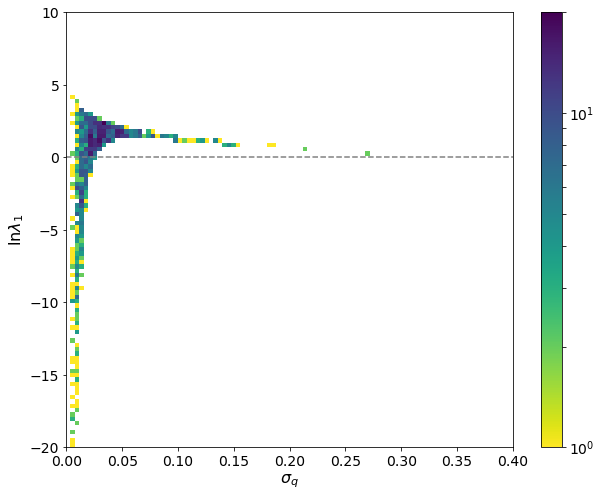

In [39]:
rcParams['figure.figsize'] = (10, 8)
from matplotlib.colors import LogNorm
hist2d(df_result.SigQ,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm(),range=[(0,0.4),(-20,10)])
colorbar()
xlabel(r"$\sigma_q$",fontsize=16)
ylabel(r'$\ln \lambda_1$',fontsize=16)
hlines(0,0,16,linestyles='--',colors='gray')
#savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vssigma.pdf")

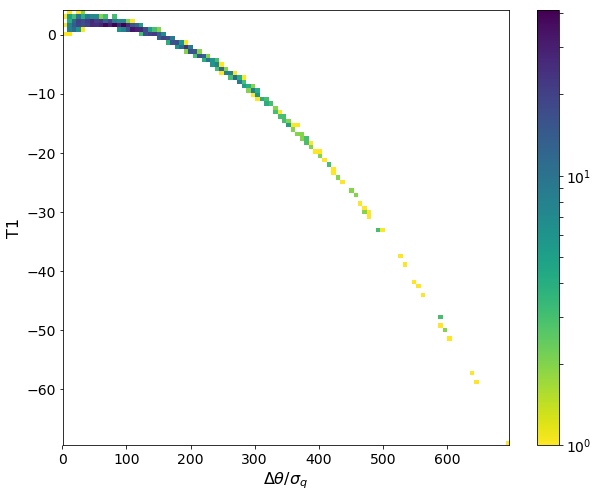

In [40]:
from matplotlib.colors import LogNorm
hist2d(df_result.SpcAng/df_result.SigQ,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$\Delta \theta / \sigma_q$",fontsize=16)
ylabel(r'T1',fontsize=16)
#savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsZ.pdf")

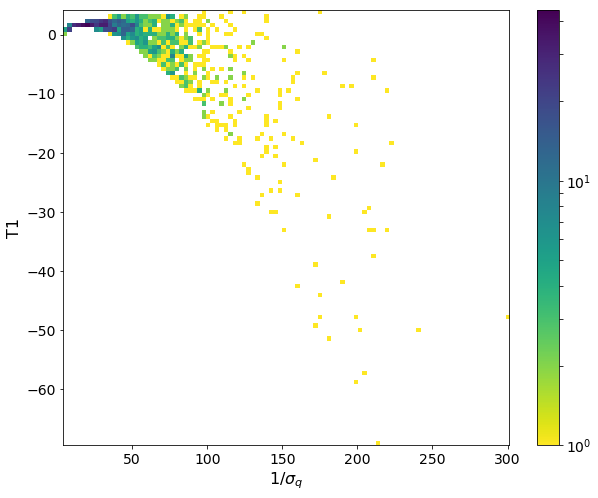

In [41]:
rcParams['figure.figsize'] = (10, 8)
from matplotlib.colors import LogNorm
hist2d(1/df_result.SigQ,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$1/\sigma_q$",fontsize=16)
ylabel(r'T1',fontsize=16)
#ylim(-1,0)

(array([   53.,    30.,    32.,    26.,    26.,    29.,    26.,    42.,
           46.,    29.,    30.,    32.,    33.,    38.,    42.,    42.,
           40.,    61.,    55.,    62.,    69.,    74.,    62.,    87.,
           86.,    84.,    92.,   110.,   104.,   120.,   115.,   136.,
          153.,   148.,   182.,   172.,   185.,   211.,   232.,   246.,
          273.,   297.,   325.,   373.,   364.,   479.,   489.,   571.,
          694.,   690.,   854.,   960.,  1178.,  1637.,  4210.]),
 array([ 2.96434   ,  3.04126145,  3.11818291,  3.19510436,  3.27202582,
         3.34894727,  3.42586873,  3.50279018,  3.57971164,  3.65663309,
         3.73355455,  3.810476  ,  3.88739745,  3.96431891,  4.04124036,
         4.11816182,  4.19508327,  4.27200473,  4.34892618,  4.42584764,
         4.50276909,  4.57969055,  4.656612  ,  4.73353345,  4.81045491,
         4.88737636,  4.96429782,  5.04121927,  5.11814073,  5.19506218,
         5.27198364,  5.34890509,  5.42582655,  5.502748  ,  5.5

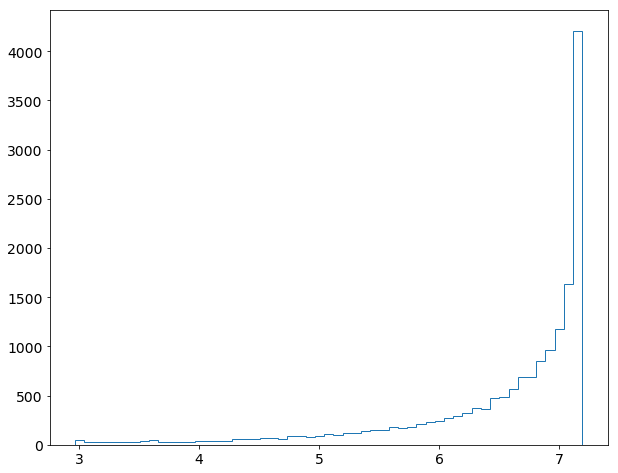

In [42]:
rcParams['figure.figsize'] = (10, 8)
#hist(df_result.Best_pos_err[df_result.LLH>-20],bins=50,histtype='step',)
hist(dfh.Hduration,bins=55,histtype='step')
#hist(df_result.Best_pos_err[df_result.LLH>48],bins=110,histtype='step')
#hist(df_result.SigQ,bins=50,histtype='step')
#hist(df_result.ICDec,bins=50,histtype='step')
#xlim(0,0.55)

(-20, 10)

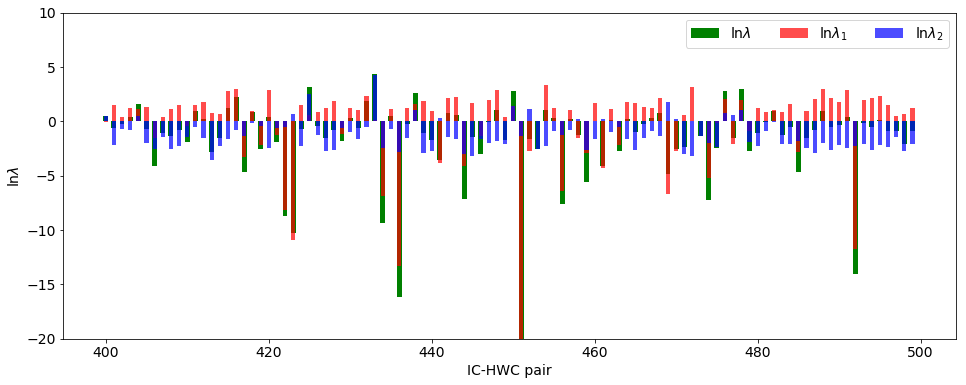

In [43]:
rcParams['figure.figsize']=16,6
x=np.arange(0,len(df_result))
mini=400
maxi=500
bar(x[mini:maxi],df_result.LLH[mini:maxi],label=r'$\ln \lambda$',width=0.6,color='g')
bar(x[mini:maxi],df_result.T1[mini:maxi],label=r'$\ln \lambda_1$',width = 0.5,color='r',alpha=0.7)
bar(x[mini:maxi],df_result.T2[mini:maxi],label=r'$\ln \lambda_2$',width = 0.5,color='b',alpha=0.7)
legend(ncol=3)
xlabel("IC-HWC pair")
ylabel(r"$\ln \lambda$")
ylim(-20,10)
#savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/indllh.pdf")

In [417]:
def smallLikelihood(dst,sigc):
    llh =  - dst**2/(2*sigc)
    return llh

X,Y = meshgrid(df_result.SpcAng,df_result.Best_pos_err**2)
Z = smallLikelihood(X,Y).T



In [177]:
max(df_result.Best_pos_err)

15.477248331498567

In [186]:
Nside = 32
degree = np.pi/180.
sky99 = np.zeros(hp.nside2npix(Nside))
sky95 = np.zeros(hp.nside2npix(Nside))
perc99 = np.percentile(df_result.LLH,99)
perc95 = np.percentile(df_result.LLH,95)
for i,r in df_result.iterrows():
    dec =  r['Best_fit_dec']
    th = 90.-dec
    ra = r['Best_fit_ra']
    j=hp.ang2pix(Nside,th*degree,ra*degree)
    if r['LLH'] > perc99:
        sky99[j] = r["LLH"]
    if r['LLH'] > perc95:
        sky95[j] = r["LLH"]

0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.


48.96561881005988

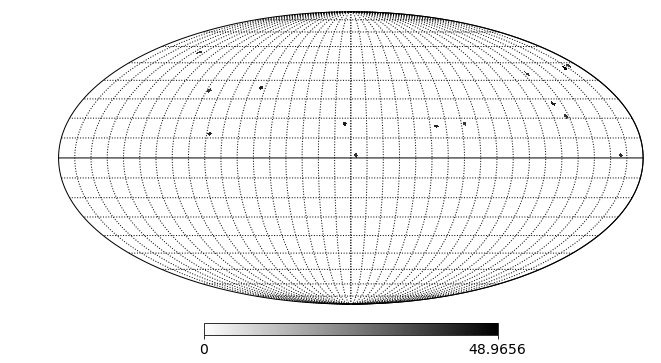

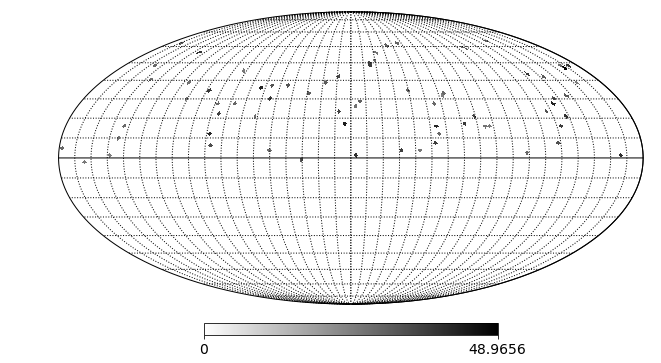

In [187]:
hp.mollview(sky99,rot=180,title='',cmap='gray_r')
hp.graticule(dpar=10)
hp.mollview(sky95,rot=180,title='',cmap='gray_r')
hp.graticule(dpar=10)
np.max(df_result.LLH)

In [135]:
dfic = pd.read_csv("IC_scrambled/0.csv".format(i))
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')
dfic.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec
5147,37.6468,234.510,0.748392,2016-01-01 00:00:40,687458
7014,16.2288,251.664,1.456150,2016-01-01 00:07:29,848553
1218,37.7610,252.420,0.927968,2016-01-01 00:09:24,249790
8163,10.7883,100.428,8.220370,2016-01-01 00:11:59,139309
5878,87.2418,163.700,0.399145,2016-01-01 00:15:36,873420


In [143]:
spca = 3.5
df_result=[]
for i in range(600):
    #HAWC sim
    dfh = pd.read_csv("HAWC_simulations/2016-01-01_{}-times.txt".format(i+1),delimiter=" ")
    dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
    dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
    #IC sim
    dfic = pd.read_csv("IC_scrambled/{}.csv".format(i))
    dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
    dfic = dfic.sort_values(by='ICtime')
    df_result.append(spcang_trange_llh(dfic, dfh, spca))
    df_result[i].to_csv("bkg_coinc/IC_HAWC_bkg_{}.csv".format(i),
          index=False,encoding='utf-8')

In [144]:
#1367
len(df_result)
flat = pd.concat(df_result,ignore_index=True)

(-20, 10)

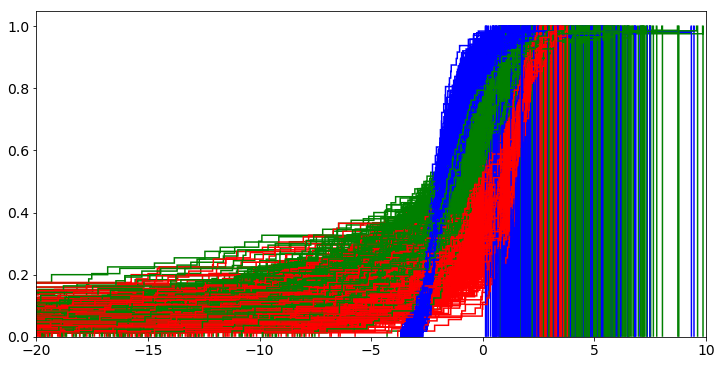

In [145]:
for i in xrange(len(df_result)):
    cllh=plt.hist(df_result[i].LLH,cumulative=True,normed=1,
         histtype='step',
         color='g',
         lw=1.5,
         bins=2000,
         label='bkg')
    cllh=plt.hist(df_result[i].T1,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.5,
         bins=2000,
         label='bkg')
    cllh=plt.hist(df_result[i].T2,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.5,
         bins=2000,
         label='bkg')
xlim (-20,10)

(-20, 10)

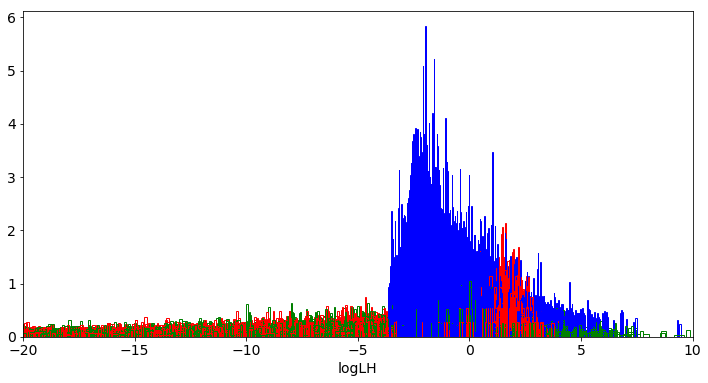

In [146]:
for i in xrange(len(df_result)):
    llh=plt.hist(df_result[i].LLH,cumulative=False,normed=1,
         histtype='step',
         color='g',
         lw=1.,
         bins=200,
         label='bkg')
    llh=plt.hist(df_result[i].T1,cumulative=False,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=200,
         label='bkg')
    llh=plt.hist(df_result[i].T2,cumulative=False,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=200,
         label='bkg')
xlabel("logLH")
xlim(-20,10)

(-20, 10)

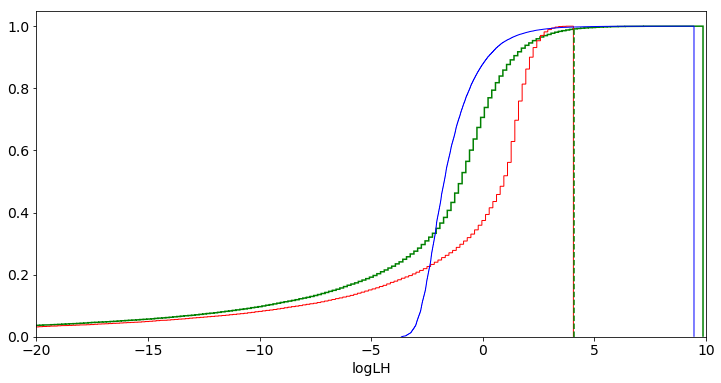

In [147]:
rcParams['figure.figsize']=12,6
perc1 = np.percentile(flat.LLH,99)


cllh=plt.hist(flat.LLH,cumulative=True,normed=1,
         histtype='step',
         color='g',
         lw=1.5,
         bins=2000,
         label='bkg')
cllh=plt.hist(flat.T1,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=2000,
         label='bkg')
cllh=plt.hist(flat.T2,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=2000,
         label='bkg')
plt.vlines(perc1,0,0.99,color='g',linestyles='--')

xlabel('logLH')
xlim(-20,10)

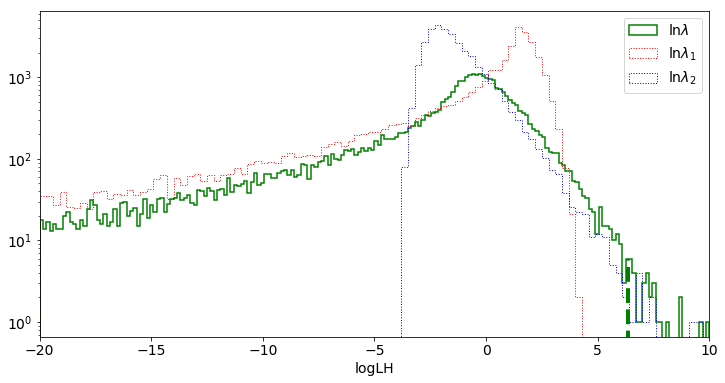

In [174]:
rcParams['figure.figsize']=12,6
alpha = 0.001
p=(1-alpha)*100
perc1 = np.percentile(flat.LLH,p)

llh=plt.hist(flat.LLH,cumulative=False,normed=0,
         histtype='step',
         color='g',
         lw=1.5,
         bins=200,
         label=r'ln$\lambda$',
         range=(-20,10))
t1=plt.hist(flat.T1,cumulative=False,normed=0,
         histtype='step',
         color='r',
         lw=1.,
         bins=100,
         label=r'ln$\lambda_1$', ls=':',
         range=(-20,10))
t2=plt.hist(flat.T2,cumulative=False,normed=0,
         histtype='step',
         color='b',
         lw=1.,
         bins=100,
         label=r'ln$\lambda_2$',ls=':',
         range=(-20,10))
h=np.searchsorted(llh[1],perc1)-1
plt.vlines(perc1,0,llh[0][h],color='g',linestyles='--',lw=4)

legend()
xlabel('logLH')
xlim(-20,10)
yscale('log')
#ylim(0,720)

In [149]:
len(flat.T1)

32885

In [154]:
np.searchsorted(llh[1],perc1)
len(flat.LLH[flat.LLH>perc1])*30/1000. 

9.87

In [169]:
alpha = 0.001
p=(1-alpha)*100
perc1 = np.percentile(flat.LLH,p)
far=len(flat.LLH[flat.LLH>perc1])*30./600.
print p,perc1,far

99.9 6.37208076023 1.65


In [19]:
import healpy as hp

In [150]:
Nside = 64
degree = np.pi/180.
sky = np.zeros(hp.nside2npix(Nside))
sky2 = np.zeros(hp.nside2npix(Nside))
perc1 = np.percentile(flat.LLH1,99)
perc2 = np.percentile(flat.LLH2,99)
for i,r in flat.iterrows():
    dec =  r['Best_fit_dec']
    th = 90.-dec
    ra = r['best_fit_ra']
    j=hp.ang2pix(Nside,th*degree,ra*degree)
    if r['LLH1'] > perc1:
        sky[j] = r["LLH1"]
        #print "Time1: ",r['HTime_c']
    if r['LLH1'] > perc2:  
        sky2[j] = r["LLH2"]
        print "Time2: ",r['HTime_c']

Time2:  2016-01-02 14:35:48
Time2:  2016-01-05 04:16:19
Time2:  2016-01-05 04:16:19
Time2:  2016-01-06 09:16:04
Time2:  2016-01-07 00:23:50
Time2:  2016-01-10 21:24:04
Time2:  2016-01-10 23:36:12
Time2:  2016-01-11 23:07:00
Time2:  2016-01-16 10:02:42
Time2:  2016-01-17 10:13:08
Time2:  2016-01-20 12:18:42
Time2:  2016-01-21 06:24:49
Time2:  2016-01-21 22:46:17
Time2:  2016-01-22 15:18:53
Time2:  2016-01-23 13:50:49
Time2:  2016-01-24 16:42:24
Time2:  2016-01-26 00:05:14
Time2:  2016-01-26 15:26:15


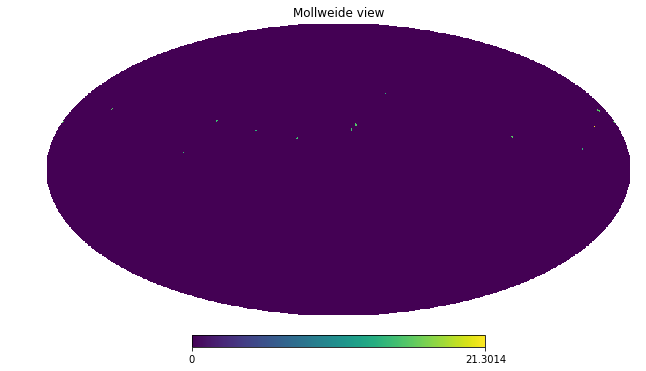

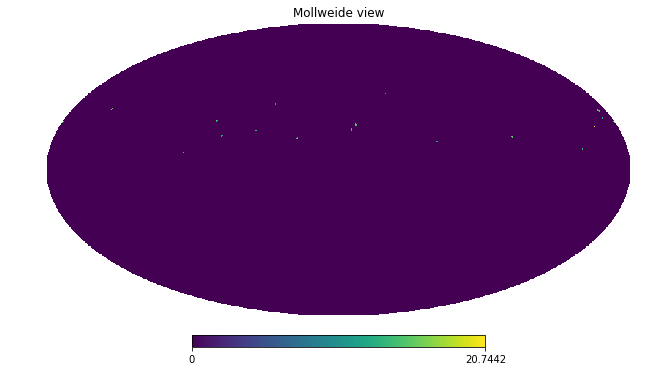

In [147]:
hp.mollview(sky,rot=180,min = 0)
hp.mollview(sky2,rot=180,min = 0)

## Archived: everything down here is archived in case we need them later

In [ ]:
# The first likelihood method that we used but we realized it is not completely right since at larger angular separation, it malfunctions.
def LLH1(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#0.11#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    if abs(ra1-ra2)>300:
        if ra1>ra2:
            ra1=ra1-360
        else:
            ra2=ra2-360
    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
    if ra_best < 0 : ra_best_report = ra_best + 360
    else : ra_best_report = ra_best
    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
    sigma = 1/(1/sigma1**2+1/sigma2**2)
    #llh1 = ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2) + \
          #2*np.log(sigma1) + ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2) + \
          #2*np.log(sigma2) - np.log(1-2*stats.norm.sf(abs(sig)))
            
    llh = -np.log(2*np.pi*sigma1)/2 - ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2)\
           -np.log(2*np.pi*sigma2)/2 - ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2)\
           + sig**2 
    
    return [dec_best, ra_best_report,llh,np.sqrt(sigma)] 

# The second likelihood method we used, but we decided to add more careful-studied IC and HAWC significance terms
def LLH2(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    if abs(ra1-ra2)>300:
        if ra1>ra2:
            ra1=ra1-360
        else:
            ra2=ra2-360
    #ra_best = (ra1/sigma1**2+ra2/sigma2**2)/(1/sigma1**2+1/sigma2**2)
    #this is identical to the following line which is used in llh1 as well
    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
    if ra_best < 0 : ra_best = ra_best + 360
    else : ra_best = ra_best
    #dec_best = (dec1/sigma1**2+dec2/sigma2**2)/(1/sigma1**2+1/sigma2**2)
    #this is identical to the following line which is used in llh1 as well
    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
    
    #trying to be conservative
    sigmac = sigma1**2 + sigma2**2
    spc = spcang(ra1,ra2,dec1,dec2)
    llh = -np.log(2*np.pi*sigmac)/2 - spc**2/(2*sigmac) + sig**2
    return [dec_best, ra_best, llh, np.sqrt(sigmac)] 

def spcang_trange_llh1 (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            
            if spc < minspc :
                #print i,j
                llh_list = LLH1(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[3], llh_list[2]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','LLH'])
    return result

def spcang_trange_llh2 (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            
            if spc < minspc :
                #print i,j
                llh_list = LLH2(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[3], llh_list[2]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','LLH'])
    return result


In [93]:
from astropy.time import Time
t=Time(57419.47016,format='mjd')
t.format='isot'
pd.to_datetime(t.value)

Timestamp('2016-02-01 11:17:01.824000')

In [19]:
t=str(data['ICtime'][1])[0:10]+"T"+str(data['ICtime'][1])[11:]
d = dateutil.parser.parse(t)
d.strftime('%m/%d/%Y')

'01/12/2016'